In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import random

from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import gym
from gym.spaces import Discrete, Tuple

from env import MetaGames
from rmax_1 import RmaxAgent, Memory

def discretize(number, radius):
     #return (torch.round(torch.div(number, radius))) * radius
    return torch.round(torch.div(number, radius)) * radius

In [2]:
inner_gamma = 0.9         #inner game discount factor
meta_gamma = 0.9          #meta game discount factor
meta_alpha = 0.4          #meta game learning rate
R_max = 0.98
inner_steps = 100
meta_epi = 3000
meta_steps = 500

epsilon = 0.35
radius = 2                #radius for discretization, assuming radius>1

#reward tensor for plotting purposes [episode, step, agents]
plot_rew = torch.zeros(meta_epi, meta_steps, 2).to(device)    

# creating environment
env = MetaGames("PD")

memory = Memory()
rmax = RmaxAgent(env, R_max, meta_gamma, inner_gamma, radius, epsilon)

In [5]:
for episode in tqdm(range(meta_epi)): #for each meta-episode
    #initialise meta-state and meta-action randomly
    meta_s = rmax.index_to_table(env, random.randint(0, rmax.meta_size*2), 2)
    memory.states.append(meta_s) 
    
    for step in range(meta_steps):    #for each meta time step
        #reset environment (i.e. inner_action & inner_r)
        env.reset()  
        #previous meta-state[0] set as our policy of the next game
        env.innerq[0,:,:] = meta_s[0].detach().clone()
        #--------------------------------------START OF INNER GAME--------------------------------------
        inner_s = env.init_state
        for t in range(inner_steps):
            #select inner-action with epsilon greedy 
            #LOOK AT > EPSILON CASE LATER
            oppo_action = env.select_action(env.state_mapping(inner_s, "oppo")).detach().clone()    
            our_action = env.action_unmapping(torch.argmax(env.innerq[0, env.state_mapping(inner_s, "our"),:]).to(device))

            #run inner game according to best_action
            state, reward, info = env.step(our_action, oppo_action)  
            
            if t == 0:   #for init_state, update row 0
                #update inner r matrix [agent, state, action], state = 1/2/3/4
                env.innerr[0, 0, env.action_mapping(our_action)] = reward.detach().clone() 
                env.innerr[1, 0, env.action_mapping(oppo_action)] = info.detach().clone()
                #update opponent's inner q matrix
                env.innerq[1, 0, env.action_mapping(oppo_action)] = info.detach().clone() + inner_gamma * torch.max(env.innerq[1,env.state_mapping(inner_s, "oppo"),:])

            else:
                #update inner r matrix [agent, state, action], state = 1/2/3/4
                env.innerr[0, env.state_mapping(inner_s, "our"), env.action_mapping(our_action)] = reward.detach().clone() 
                env.innerr[1, env.state_mapping(inner_s, "oppo"), env.action_mapping(oppo_action)] = info.detach().clone()
                #update opponent's inner q matrix
                env.innerq[1, env.state_mapping(inner_s, "oppo"), env.action_mapping(oppo_action)] = info.detach().clone() + inner_gamma * torch.max(env.innerq[1,env.state_mapping(inner_s, "oppo"),:])
            
        #---------------------------------------END OF INNER GAME--------------------------------------
        #save reward, info for plotting              
        plot_rew[episode,step,0] = reward.detach().clone()
        plot_rew[episode,step,1] = info.detach().clone()
        
        #meta-action = inner game Q table of our agent
        meta_a = env.innerq[0, :, :].detach().clone()
        memory.actions.append(meta_a) 
        
        #Update inner Q table, oppo agent: by Q learning
        #env.innerq[1, :, :] = (1-meta_alpha) * env.innerq[1, :, :] + meta_alpha * torch.Tensor([1-int(best_action[1]), int(best_action[1])]).to(device) * info.detach().clone()
        oppo_phi = discretize(env.innerq[1, :, :] , radius)
        
        #find index inside dictionary that corresponds to meta_s entry
        #array of indices that corresponds to meta_s
        stateind_arr = np.where(rmax.Q["state"] == rmax.find_meta_index(torch.flatten(meta_s)))[0]
        if len(stateind_arr) == 0:        #if we haven't visited that meta_s before & no record, 
            #we put random meta_action as inner Q
            our_phi = rmax.index_to_table(env, random.randint(0, rmax.meta_size), 1)
        
        else:                             #else if we visited that meta_s before
            #inner Q is the action that corresponds to max Q(meta_s)
            maxQ_ind = np.argmax([rmax.Q["Qval"][stateind_arr]])
            our_phi = rmax.index_to_table(env, rmax.Q["action"][stateind_arr[maxQ_ind]], 1)
            
        #meta-state = discretized inner game Q table of all agents,     our_phi[0] since index_to_table outputs [1,5,2]
        next_meta_s = discretize(torch.stack((our_phi[0], oppo_phi),0), radius)
        memory.states.append(next_meta_s)    
        
        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward.detach().clone()                
        memory.rewards.append(reward)
        
        #rmax update step
        rmax.update(env, memory, meta_s, meta_a, next_meta_s)

        #prepare meta_s for next step
        meta_s = next_meta_s.detach().clone()



  0%|                                                                                          | 3/3000 [01:11<19:48:13, 23.79s/it]


KeyboardInterrupt: 

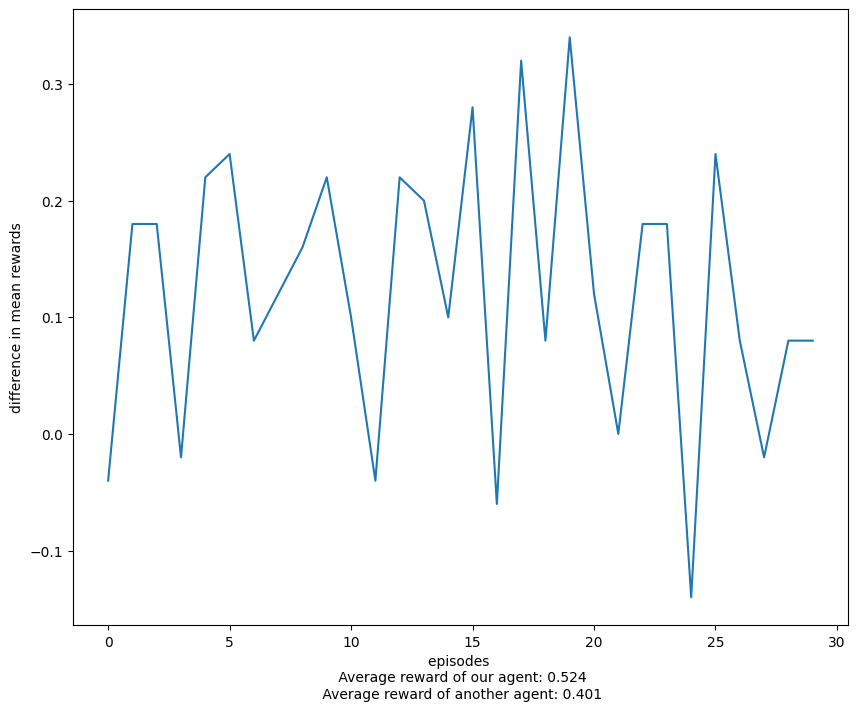

In [4]:
plot_rew_mean_diff = torch.mean(plot_rew[:,:,0],1) - torch.mean(plot_rew[:,:,1],1)
fig_handle = plt.plot(plot_rew_mean_diff.cpu().numpy())

plt.xlabel("episodes \n Average reward of our agent: " + str(round(torch.mean(plot_rew[:,:,0],(0,1)).detach().item(), 3)) + 
          "\n Average reward of another agent: " + str(round(torch.mean(plot_rew[:,:,1],(0,1)).detach().item(), 3)))

plt.ylabel("difference in mean rewards")

figure = plt.gcf() # get current figure
figure.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(max_meta_epi) + '_' + str(max_meta_steps) + '_pd.png' , dpi = 100)